Індивідуальне завдання 1, викнонав Процик Олексій

Індивідуальне завдання №1-2 «Аналіз часових рядів: графічний, кореляційний та спектральний» :

1. Графічний аналіз. Експоненційне згладжування (5 б)

 * Проаналізуйте структуру часового ряду на основі його графічного зображення (Time Series /Forecasting, Пайтон). 
 * Чи є тренд? Періодична складова? Випадкова складова? Спробуйте підібрати функцію для тренду та позбутись його, тобто побудувати ряд без тренду. 
 * Зробіть експоненційне зглажування (Статистика, Пайтон)


In [57]:
import numpy as np
import pandas as pd
import seaborn as sns

import seaborn 
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [58]:
data = pd.read_csv('TSLA.csv',parse_dates = ['Date'], index_col='Date')
data.rename(columns={'Close/Last':'Close'},inplace=True)
data = data.sort_values('Date', ascending=True)
data.drop(columns=['Volume', 'Open', 'High', 'Low'],axis=0,inplace=True)

In [59]:
data.describe()

,Close,Adj Close
count,504.000000,504.000000
mean,189.956488,189.956488
std,128.483922,128.483922
min,17.400000,17.400000
25%,34.362502,34.362502
50%,212.299996,212.299996
75%,267.242500,267.242500
max,917.419983,917.419983


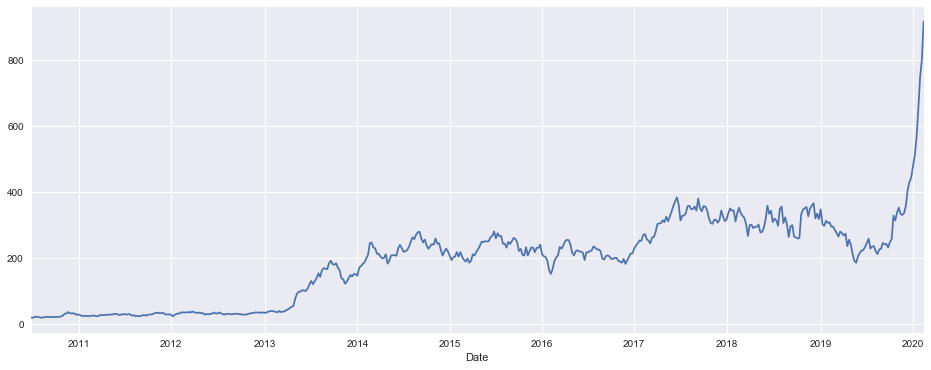

In [60]:
plt.figure(figsize=(16,6))
data.Close.plot()

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [62]:
result_add = seasonal_decompose(data['Close'],  model='additive', period=7, extrapolate_trend='freq')

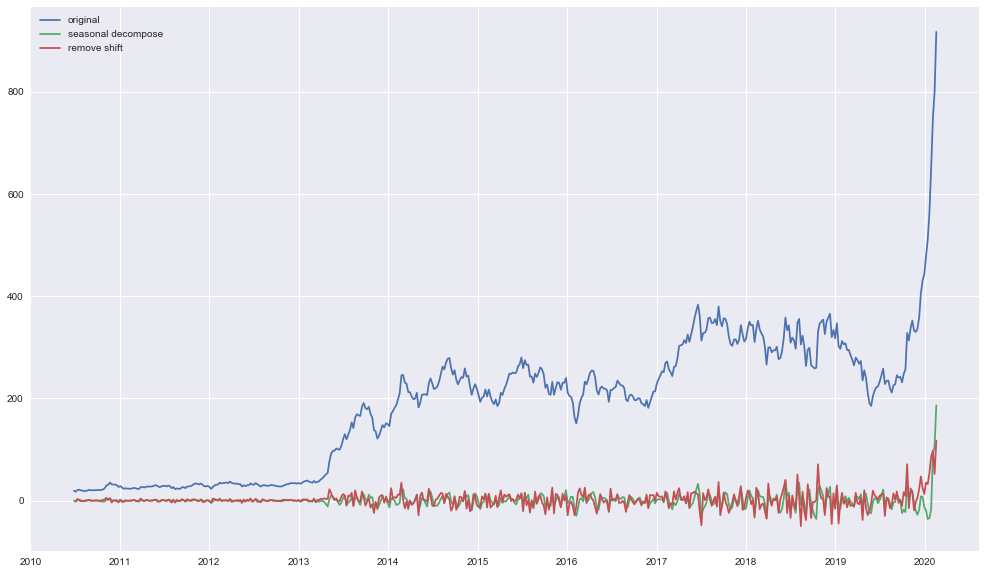

In [63]:
fig,ax = plt.subplots(figsize=(17,10))
plt.plot(data['Close'], label='original')
plt.plot(data['Close'] - result_add.trend, label='seasonal decompose')
plt.plot(data['Close'] - data['Close'].shift(1), label='remove shift')
plt.legend()

Text(0.5, 0.98, 'Additive Decompose')

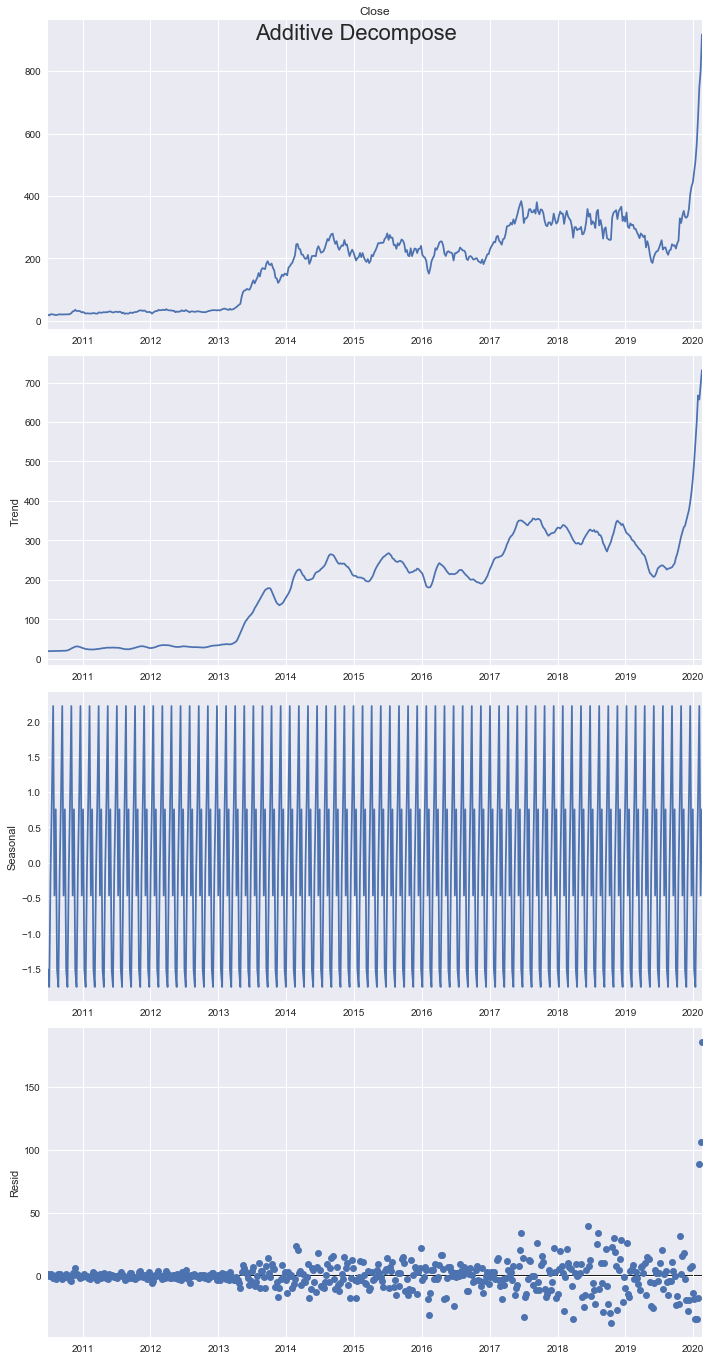

In [64]:
plt.rcParams.update({'figure.figsize': (10,19)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)

З декомпозиції видно, що є тренд та сезональність. Його можна позбутися віднявши його від ціни.

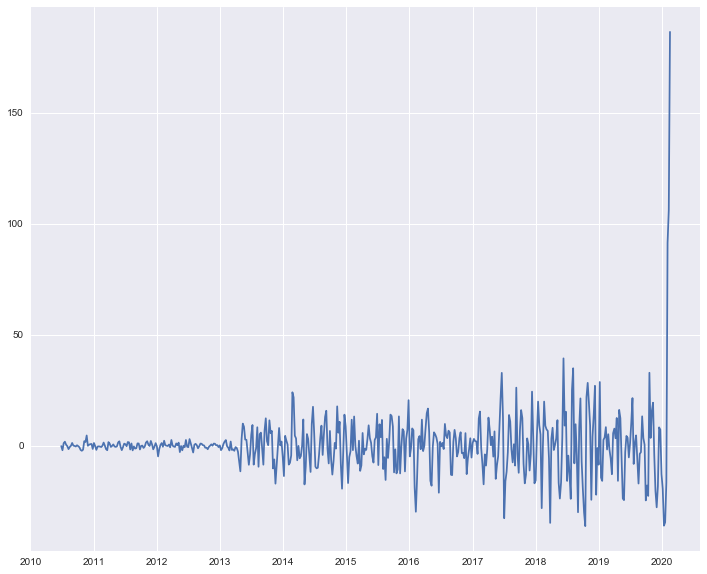

In [65]:
plt.subplots(figsize=(12,10))
plt.plot(data.Close-result_add.trend)

In [66]:
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
2010-06-28,-1.508421,19.388776,1.319646,19.200001
2010-07-05,-1.755214,19.439388,-0.284174,17.400000
2010-07-12,-0.141354,19.490000,1.291352,20.639999
2010-07-19,0.894957,19.482857,0.912187,21.290001
2010-07-26,2.215882,19.468572,-1.744452,19.940001


# Експоненційне зглажування

In [67]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

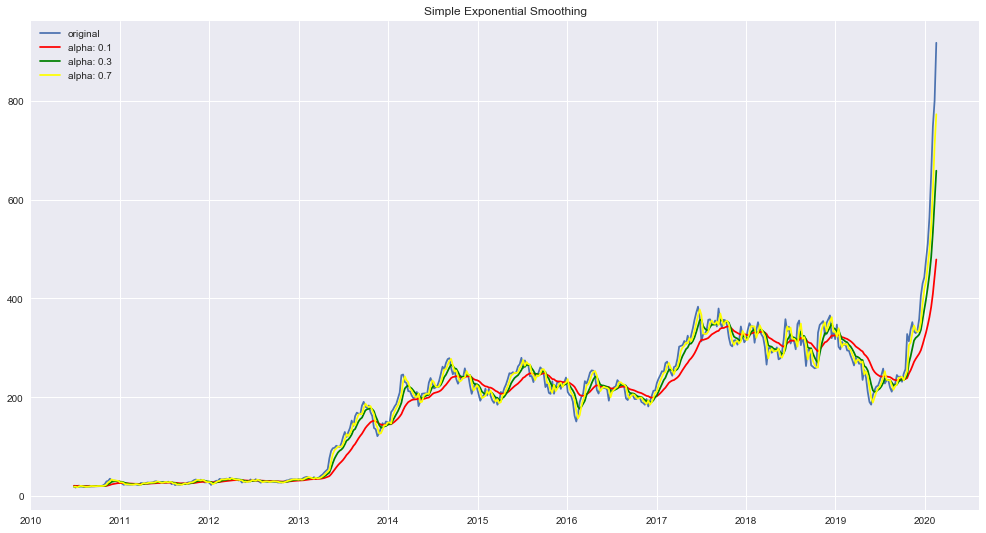

In [68]:
model = SimpleExpSmoothing(data['Close'].values)

fit1 = model.fit(.1)
pred1 = fit1.forecast(9)
fit2 = model.fit(smoothing_level=.3)
pred2 = fit2.forecast(9)
fit3 = model.fit(smoothing_level=.7)
pred3 = fit3.forecast(9)

fig, ax = plt.subplots(figsize=(17, 9))
ax.plot(data['Close'], label='original')

for p, f, c, a in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('red','green','yellow'), (0.1,0.3,0.7)):
    ax.plot(data.index, f.fittedvalues, color=c, label=f"alpha: {a}")
    
plt.title("Simple Exponential Smoothing")    
plt.legend()

# Task #2

Проведіть логарифмування ряду S_t . Чи є заданий ряд візуально схожим на
стаціонарний? Сформуйте ряд із перших різниць (диференціювання з лагом
Проаналізуйте графічне зображення отриманого ряду.

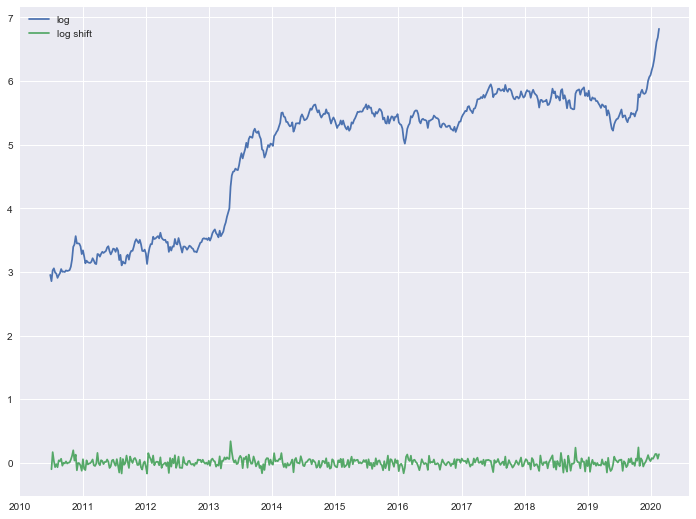

In [69]:
fig,ax = plt.subplots(figsize=(12,9))
plt.plot(data.index,np.log(data['Close']), label='log')

logarithmize = np.log(data['Close']) - np.log(data['Close'].shift())
logarithmize = logarithmize[1:]
plt.plot(logarithmize, label='log shift')
plt.legend()

Логарифмування не є схожим на стаціонарний ряд.

In [70]:
import scipy
from  statsmodels.graphics.gofplots import qqplot

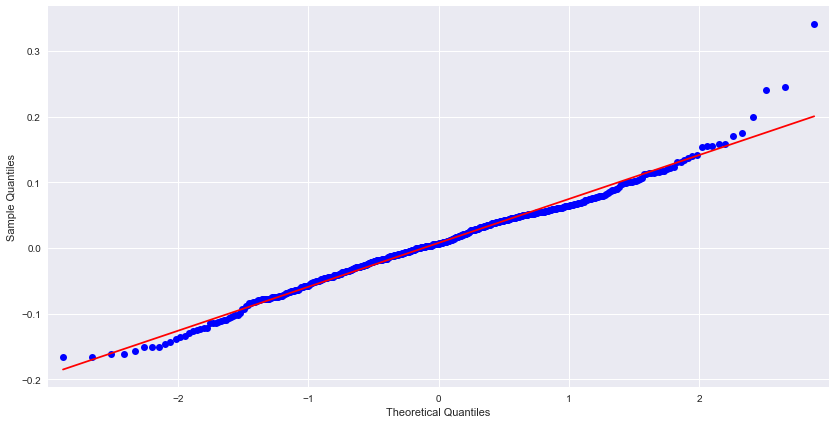

In [71]:
fig,ax = plt.subplots(figsize=(14,7))
qqplot(logarithmize,'norm',ax=ax,line='r')
plt.show()

In [72]:
from statsmodels.tsa.stattools import adfuller

In [73]:
print(f"Dickey-Fuller test on stationarity: p-value: {adfuller(logarithmize)[1]}")

Dickey-Fuller test on stationarity: p-value: 1.4584054378754436e-09


Можемо відхилити гіпотезу, що ряд є стаціонарним за нашим p-value, який значущо нижчий за 5%.

<br>

 * Проведіть кореляційний аналіз засобами пакету «Статистика» та за допомогою знаходження статистичних оцінок АКФ за формулами в Excel: $$ R_N(n)=\frac{1}{N-n}\sum_{k=0}^{N-n-1}(x_{n+k}-\mu)(x_k-\mu) \quad \rho_N(i)=\frac{R_N(i)}{R_N(0)}$$  до 15 лагу (ЧАКФ до 3-го лагу). Чи є оцінки коваріаційної функції незміщеними та конзистентними?
 * Побудуйте графіки АКФ, ЧАКФ. Порівняйте із тими, що знайдені засобами «Статистики».

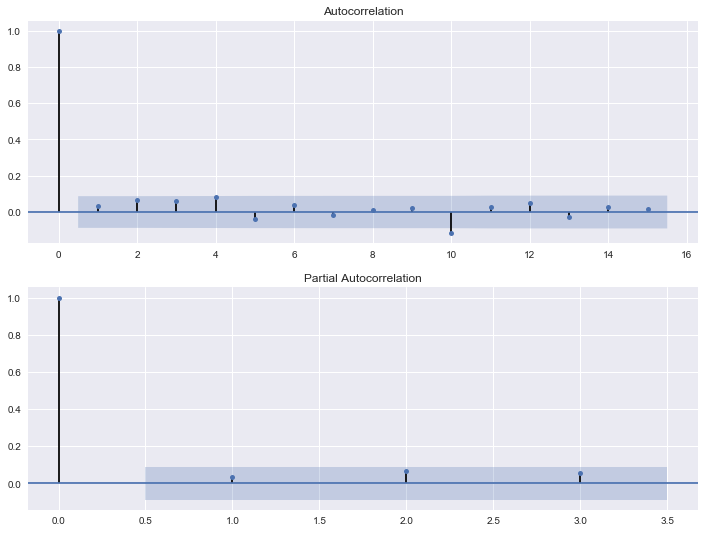

In [74]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
fig,ax = plt.subplots(2,1,figsize=(12,9))
plot_acf(logarithmize, lags=15, ax=ax[0])
plot_pacf(logarithmize, lags=3, ax=ax[1])
plt.show()

# Task #3

In [75]:
from scipy.signal import periodogram, welch

In [76]:
fourier = np.fft.fft(data['Close'].values)
_,spectral = periodogram(data['Close'].values,fs=1/(60*60*24*7), scaling='spectrum')

/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


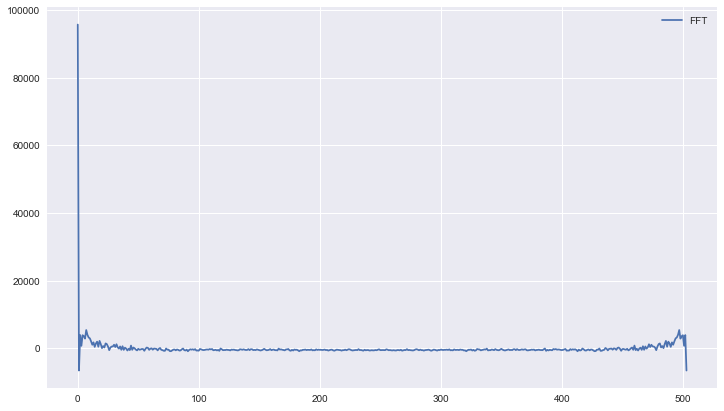

In [77]:
plt.subplots(figsize=(12,7))
plt.plot(fourier, label='FFT')
plt.legend()

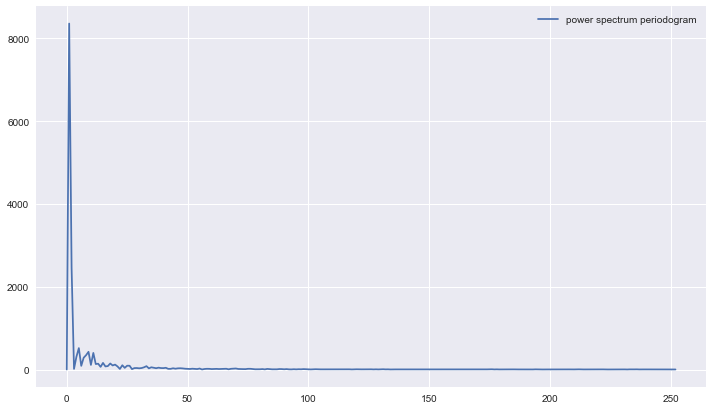

In [78]:
plt.subplots(figsize=(12,7))
plt.plot(spectral, label='power spectrum periodogram')
plt.legend()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


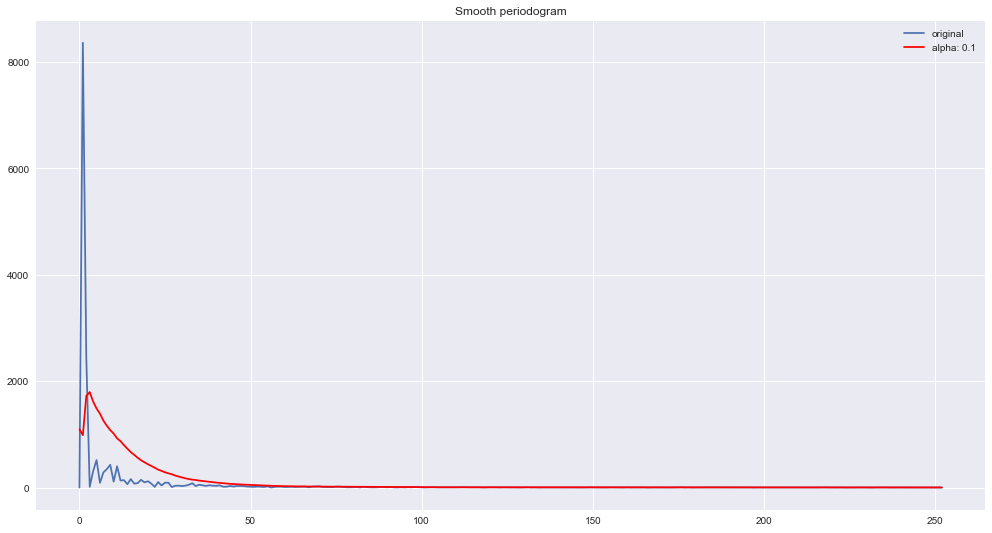

In [79]:
model = SimpleExpSmoothing(spectral)

fit1 = model.fit(.1)
pred1 = fit1.forecast(9)

fig, ax = plt.subplots(figsize=(17, 9))
ax.plot(spectral, label='original')

ax.plot(fit1.fittedvalues, color='red', label="alpha: 0.1")
    
plt.title("Smooth periodogram")    
plt.legend()

За допомогою швидкої трансформації Фур'є ми можемо чітко виділити періодичну частину в данних і таким чином знайти сезональність. За графіком чітко видно, що є періодична складова в ряді.

### 4. ARIMA моделі

<t> 4.1 (4 б) Оцініть відповідність часового ряду з перших різниць моделям
AR(1), MA(1) та ARMA(1,1) з використанням, автокореляційної та
часткової автокореляційної функцій. Знайдіть коефіцієнти для цих моделей
через значення АКФ та засобами Статистики. Порівняйте. Чи є значущими коефіцієнти у цих моделях? Запишіть ці моделі. Здійсніть засобами
Статистики прогнозування значень ряду на декілька наступних часових
періодів з побудовою довірчих інтервалів для кожної з цих моделей.

In [32]:
from statsmodels.tsa.arima_model import ARIMA, ARMA

In [33]:
def fit(data,order, title):
    ar = ARMA(data[:-5], order=order)
    results = ar.fit()
    fig,ax=plt.subplots(figsize=(12,8))
    plt.plot(data.shift())
    plt.plot(results.fittedvalues, color='red')
    plt.title(title)
    print(results.summary())
    
    _,ax = plt.subplots(figsize=(12,9))
    prediction = results.predict(1,110)
    pred = prediction.values
    interval = []
    for i in range(1,6):
        ar = ARMA(data[:-5-i], order=order)
        results = ar.fit()
        forecast = results.forecast(1,alpha=0.05)
        pred = np.concatenate((pred, forecast[0]))
        interval.append(forecast[2][0])
    interval = np.array(interval)
    plt.plot(pred,label='predict')
    plt.plot(logarithmize.values, label='data')
    plt.fill_between(range(111,111+5), interval[:,0], interval[:,1], alpha=0.2, label='95% confidence')
    plt.legend()
    plot_acf(pred)
    plot_pacf(pred)

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  111
Model:                     ARMA(0, 1)   Log Likelihood                  76.654
Method:                       css-mle   S.D. of innovations              0.121
Date:                Wed, 18 Mar 2020   AIC                           -147.308
Time:                        01:03:18   BIC                           -139.179
Sample:                    07-01-2010   HQIC                          -144.010
                         - 09-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0228      0.014      1.606      0.108      -0.005       0.051
ma.L1.Close     0.2371      0.098      2.408      0.016       0.044       0.430
                                    Roots       

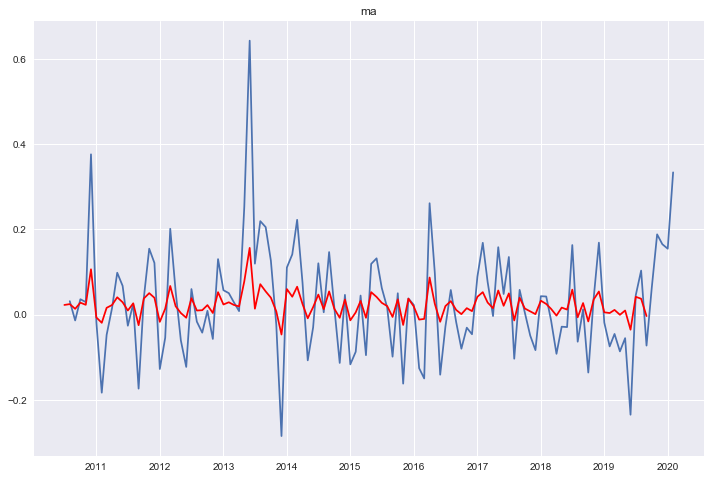

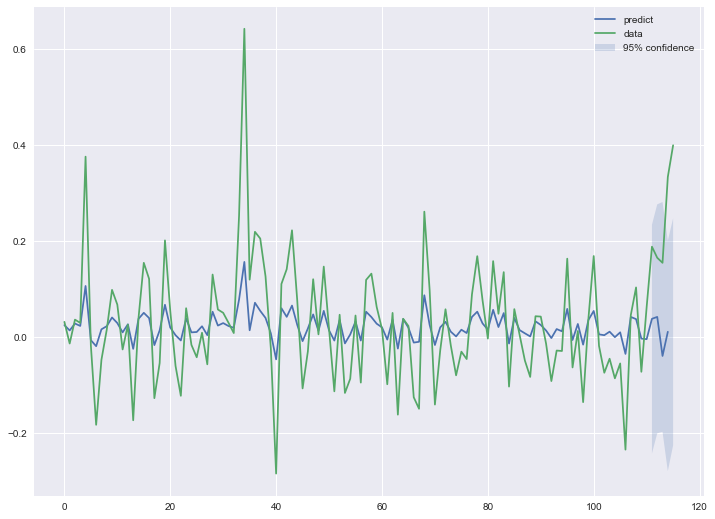

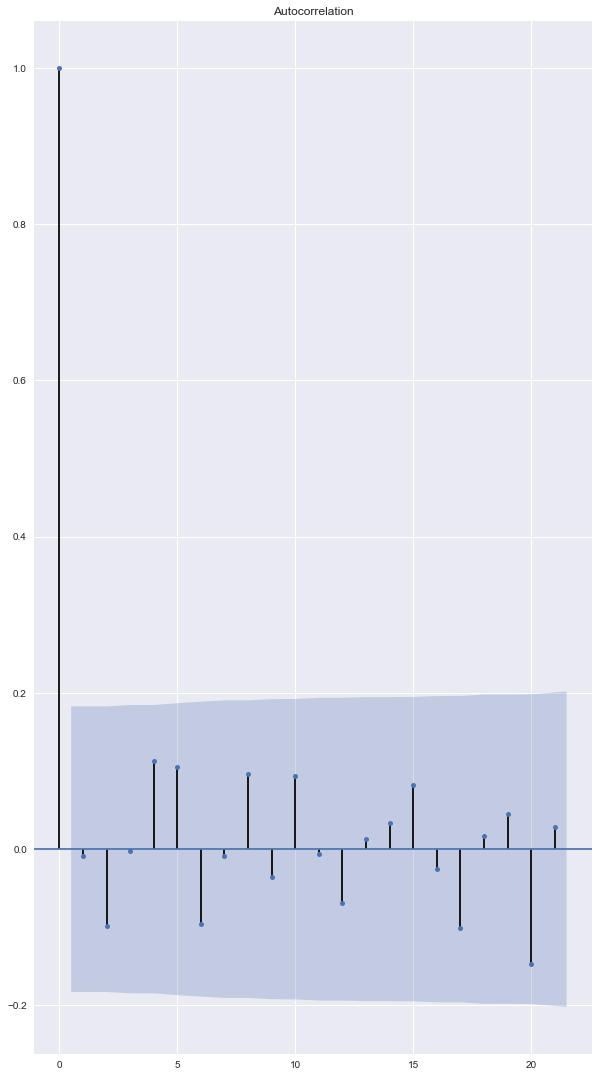

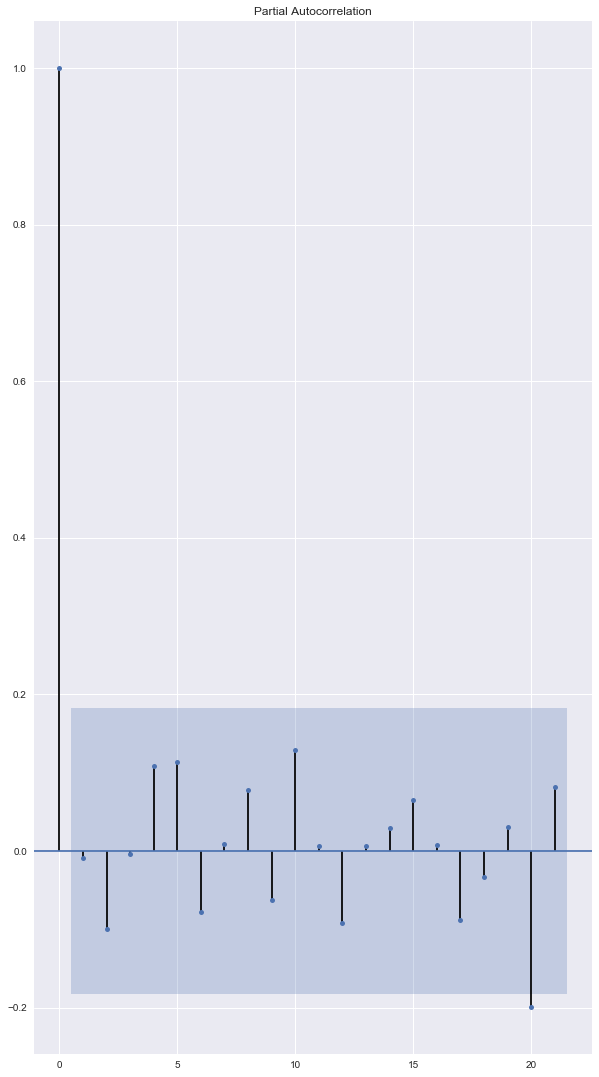

In [34]:
fit(logarithmize,(0,1),'ma')

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  111
Model:                     ARMA(1, 0)   Log Likelihood                  76.137
Method:                       css-mle   S.D. of innovations              0.122
Date:                Wed, 18 Mar 2020   AIC                           -146.274
Time:                        01:03:20   BIC                           -138.146
Sample:                    07-01-2010   HQIC                          -142.977
                         - 09-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0228      0.014      1.592      0.111      -0.005       0.051
ar.L1.Close     0.1929      0.093      2.080      0.037       0.011       0.375
                                    Roots       

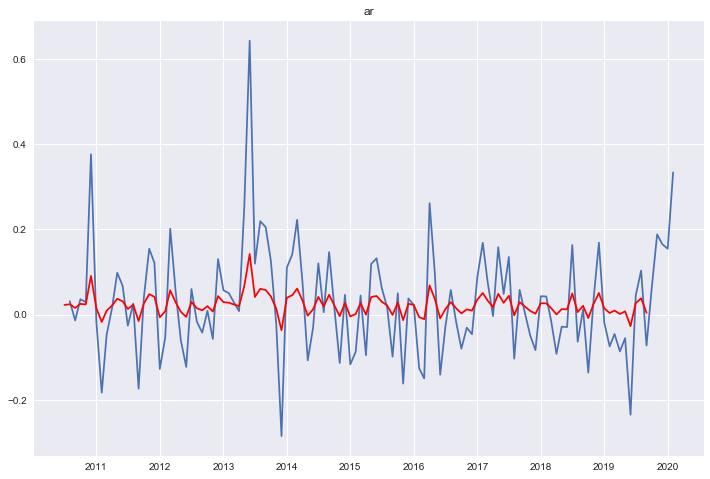

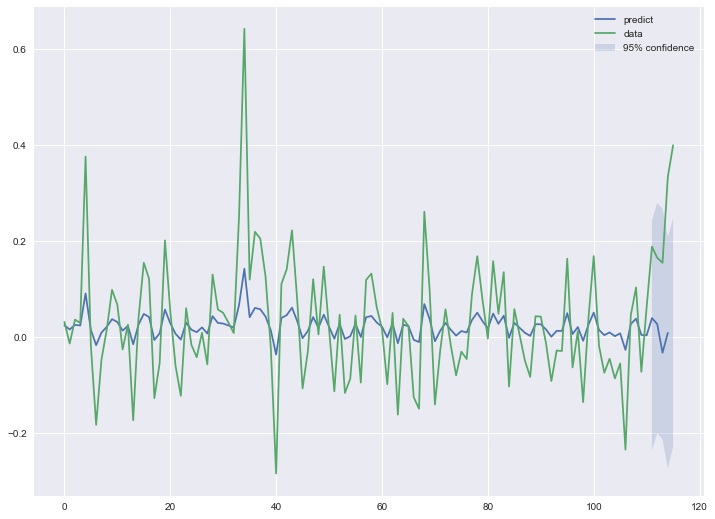

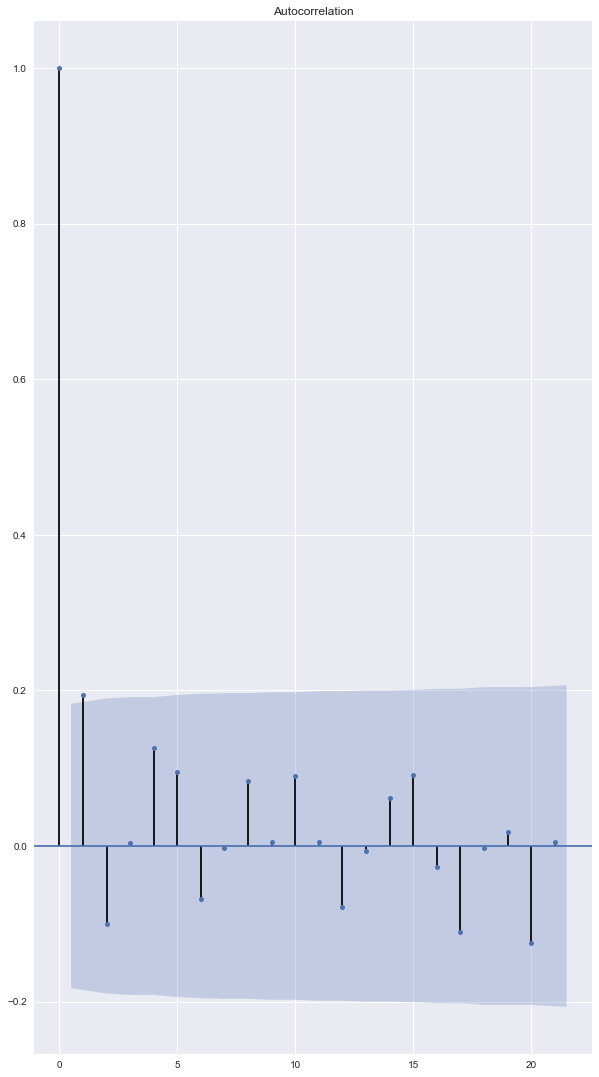

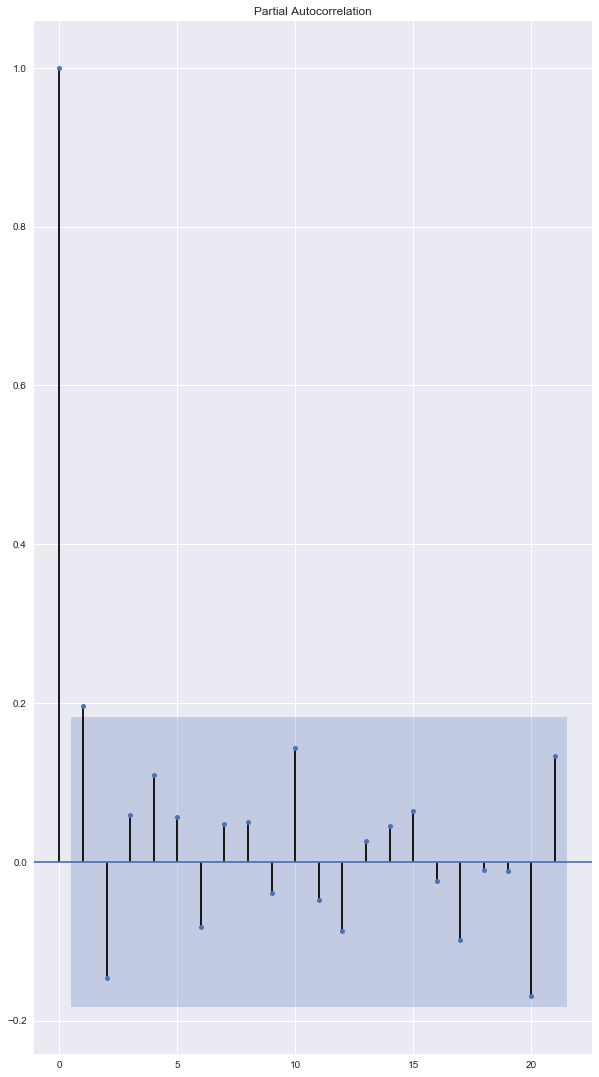

In [35]:
fit(logarithmize,(1,0),'ar')

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  111
Model:                     ARMA(1, 1)   Log Likelihood                  76.879
Method:                       css-mle   S.D. of innovations              0.121
Date:                Wed, 18 Mar 2020   AIC                           -145.758
Time:                        01:03:23   BIC                           -134.920
Sample:                    07-01-2010   HQIC                          -141.361
                         - 09-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0229      0.014      1.690      0.091      -0.004       0.049
ar.L1.Close    -0.2431      0.355     -0.685      0.493      -0.939       0.453
ma.L1.Close     0.4662      0.324      1.440    

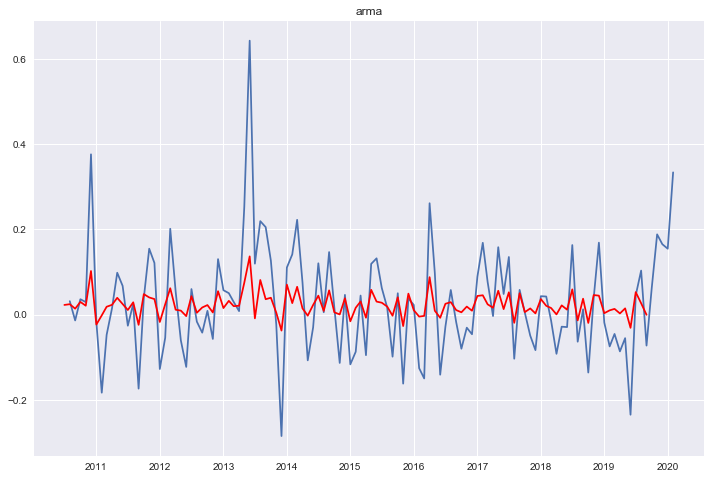

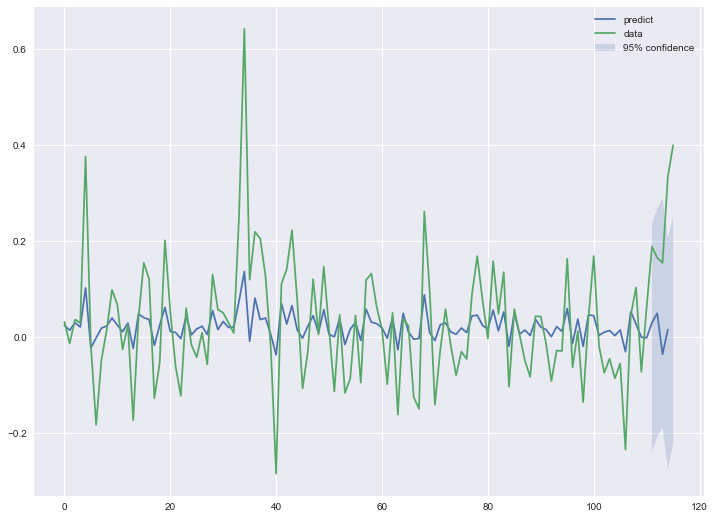

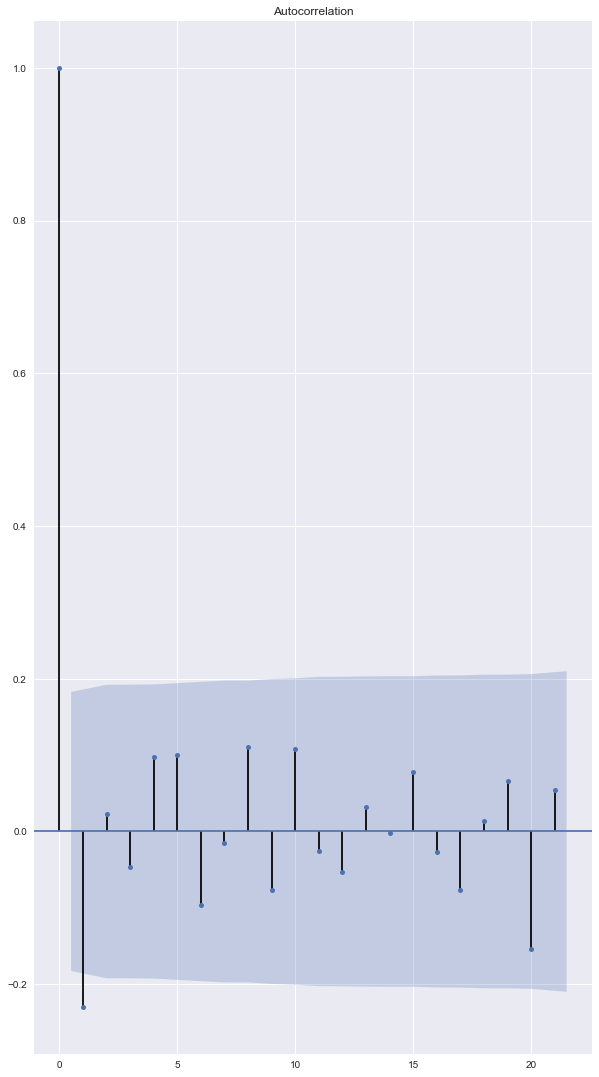

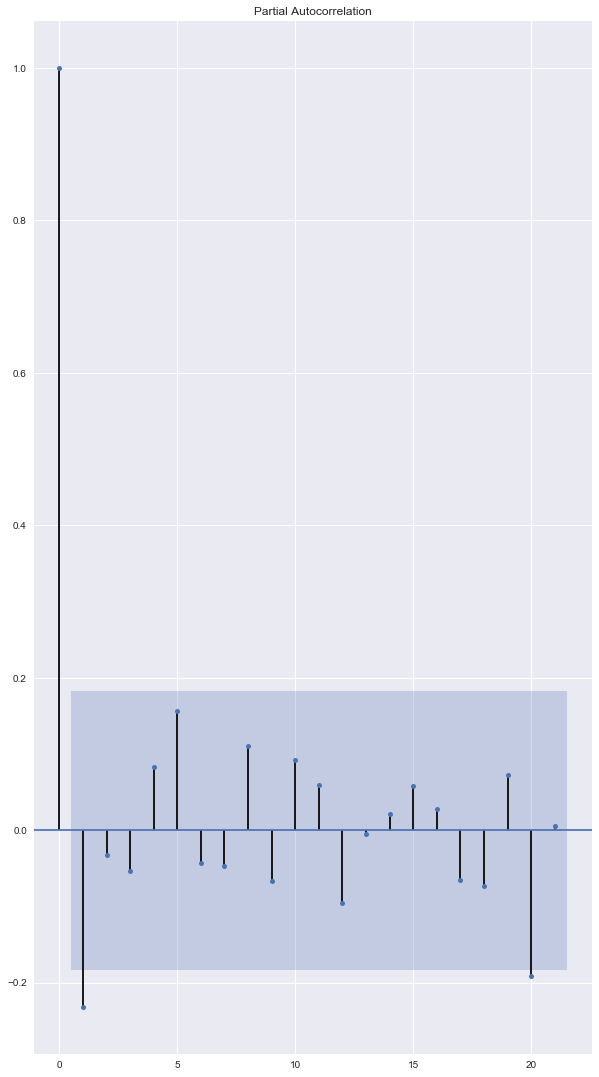

In [36]:
fit(logarithmize,(1,1),'arma')

4.2 Підберіть ARIMA(p,d,q) модель до вихідного ряду (з
використанням, автокореляційної та часткової автокореляційної функцій).
Проведіть аналіз залишків. Здійсніть прогнозування значень ряду на 2
наступних часових періоди з побудовою довірчих інтервалів. Порівняйте
цю модель з розглянутими раніше.

In [46]:
from sklearn.metrics import mean_squared_error

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train, test = X[:-15], X[-15:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    error = mean_squared_error(test, predictions)
    return error

Підберемо параметри, які мінімізують середньоквадратичне відхилення на тестовій виборці.

In [48]:
best_params = (0,0,0)
best_score = 1e+10
for i in range(0,5):
    for j in range(1,3):
        for k in range(0,2):
            params = (i,j,k)
            score = evaluate_arima_model(data.Close, params)
            if score < best_score:
                best_score = score
                best_params = params

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [50]:
best_params, best_score

((1, 2, 0), 2452.042269119075)

In [51]:
train, test = data.Close[:-5], data.Close[-5:]

model = ARIMA(train, order=best_params)
model = model.fit()
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  110
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -514.894
Method:                       css-mle   S.D. of innovations             26.076
Date:                Wed, 18 Mar 2020   AIC                           1035.787
Time:                        01:05:31   BIC                           1043.889
Sample:                    08-01-2010   HQIC                          1039.073
                         - 09-01-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0435      1.751      0.025      0.980      -3.389       3.476
ar.L1.D2.Close    -0.4235      0.086     -4.912      0.000      -0.592      -0.255
                                    

In [52]:
pred = model.predict(2,len(data)-5)

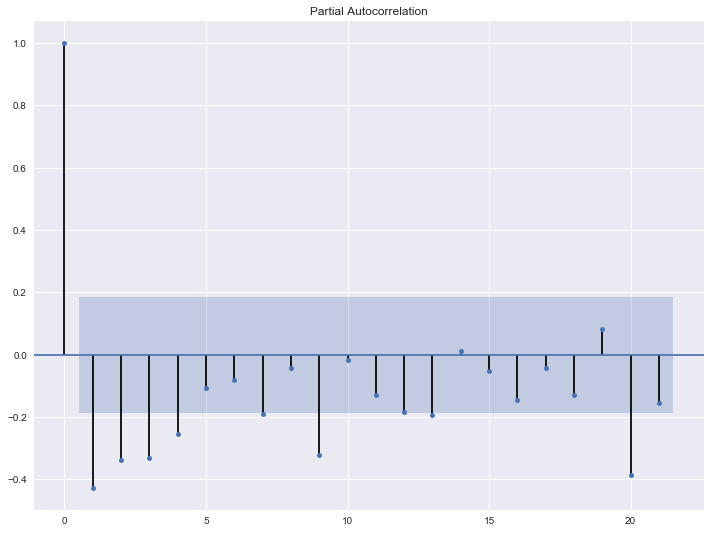

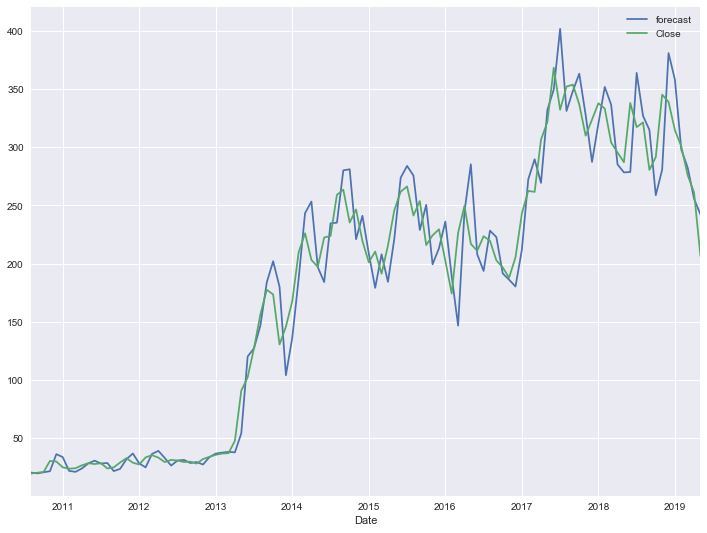

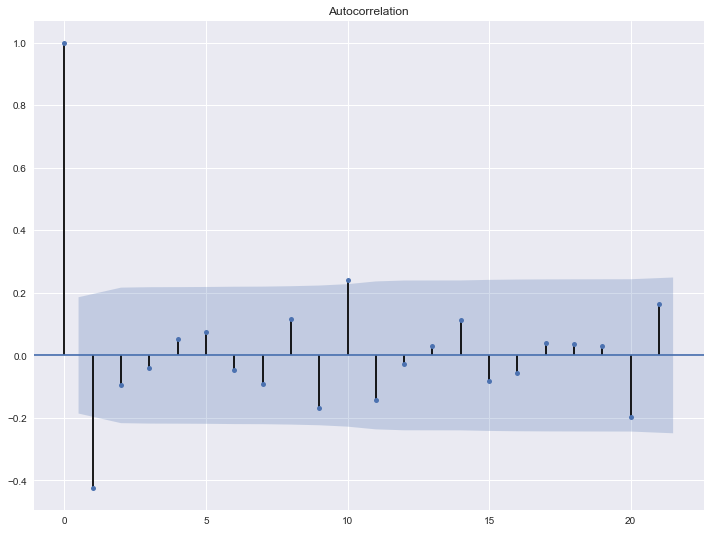

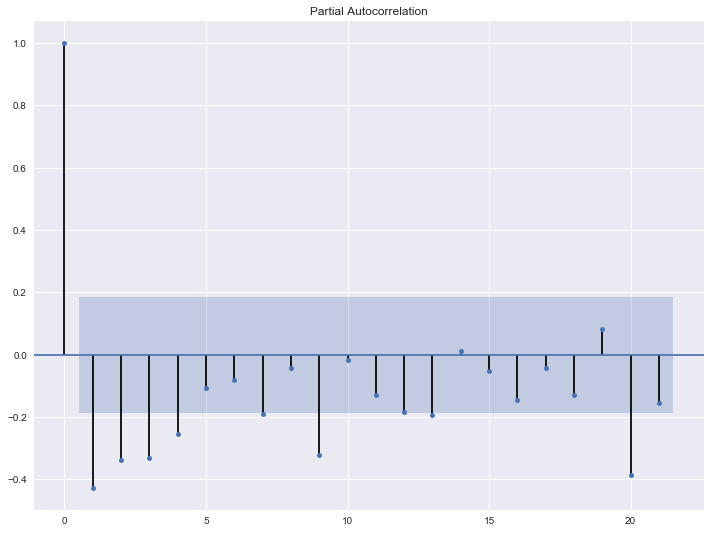

In [53]:
fig,ax=plt.subplots(figsize=(12,9))
model.plot_predict(2,len(data)-10,ax=ax)
fig,ax=plt.subplots(figsize=(12,9))
plot_acf(pred,ax=ax)
fig,ax=plt.subplots(figsize=(12,9))
plot_pacf(pred,ax=ax)

Text(0.5, 1.0, 'Залишки')

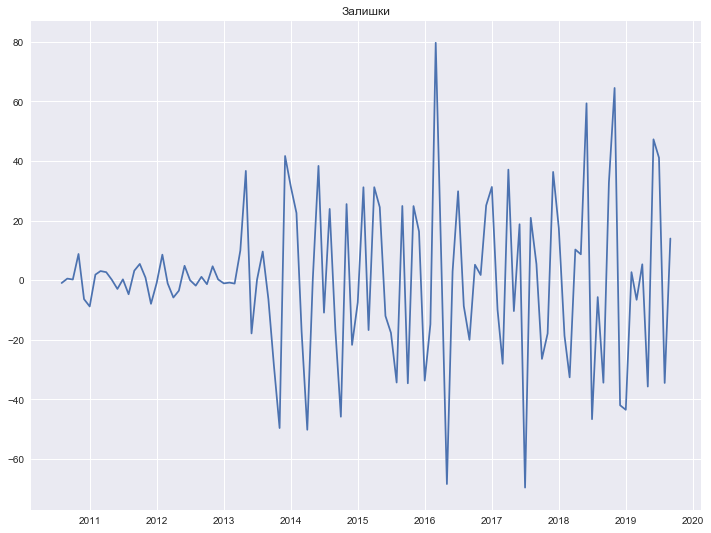

In [54]:
fig,ax=plt.subplots(figsize=(12,9))
plt.plot(model.resid)
plt.title('Залишки')

In [55]:
train, test = data.Close[:-20], data.Close[-20:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=best_params)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat[0])
    history.append(test[t])

Text(0.5, 1.0, 'Big test set prediction')

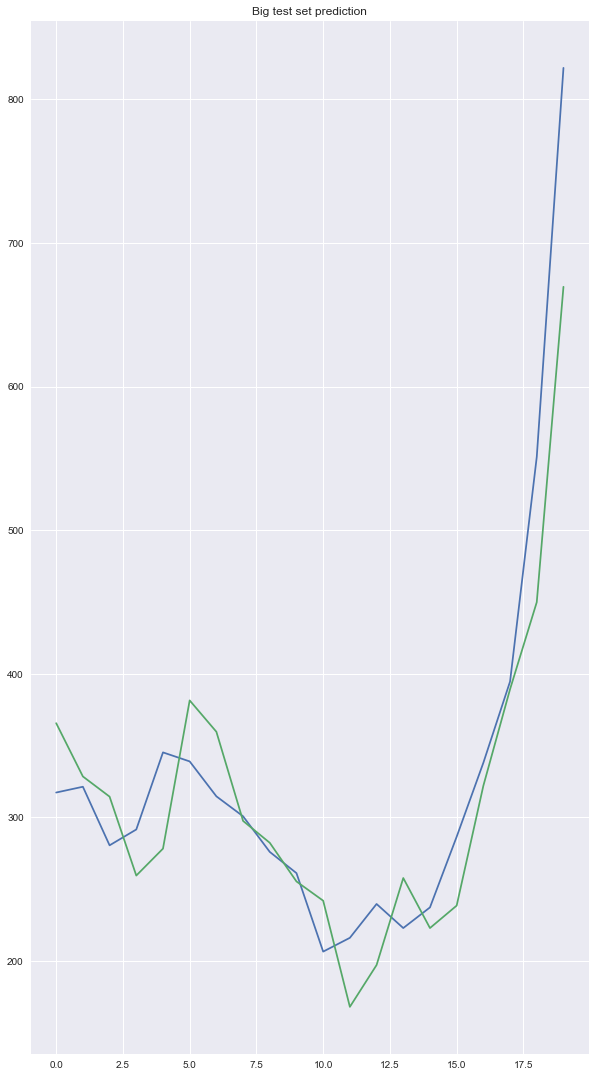

In [80]:
plt.plot(test.tolist())
plt.plot(predictions)
plt.title('Big test set prediction')